* 決定木分類器：意味解釈可能性に配慮する場合に魅力的
* 意味解釈可能性(interpretability):得られた結果の意味を解釈しやすいかどうか
* 情報利得(Information gain):分割された集合の要素についてのばらつきの減少
* 葉が純粋になる：分割されたデータのばらつきの減少がなくなる（=IGが最大）

## 決定木の目的関数

情報利得を最大化するようにする。

$$ IG(D_p,f) = I(D_p)- \sum_{i=1}^m \frac{N_j}{N_p}I(D_j) $$

* \\( f \\):分割を行う特徴量
* \\( D_p \\):親ノードのデータセット
* \\( D_j \\):j番目の子ノードのデータセット
* \\( I \\):不純度(ノードに異なるクラスのサンプルがどの程度の割合で混ざっているかを表す指標)
* \\( N_p \\):親ノードのサンプルの総数
* \\( N_j \\):j番目の子ノードのサンプルの個数
* 子ノードの不純度が低いほど情報利得は大きくなる

## 二分決定木

組み合わせ探索空間を減らすために2つの子ノードにする

$$ IG(D_p,f) = I(D_p)- \frac{N_{left}}{N_p}I(D_{left}) - \frac{N_{right}}{N_p}I(D_{right}) $$

#### 二分決定木でよく使用される不純度の指標または分割条件

* ジニ不純度(Gini impurity):\\( I_G \\)
* エントロピー(entropy):\\( I_H \\)
* 分類誤差(classification error):\\( I_E \\)

### エントロピー

エントロピーは相互情報量(2つの確率の相互依存度)が最大化するように試みる条件である

$$ I_H(t) = -\sum_{i=1}^c p( \, i \: | \: t \, )\log_2 p( \, i \: | \: t \, ) $$

* \\( p( \, i \: | \: t \, ) \\):特定のノードtに暮らすiに属するサンプルの割合
* 全てのサンプルが同じクラスに属しているとエントロピーは0
* 二値分類で双方のクラスに一様に分布するとエントロピーは1(こちらにしたい)

### ジニ不純度

ジニ不純度は誤分類の確率を最小化する条件である。

$$ I_G(t) = -\sum_{i=1}^c p( \, i \: | \: t \, )(1-p( \, i \: | \: t \, )) = 1 - \sum_{i=1}^c p( \, i \: | \: t \, )^2 $$

これもクラスが完全に混合化されているときに最大化する。

### 誤差分類

$$ I_E(t) = 1- \mathrm{max} \{ p (i \, | \, t) \} $$

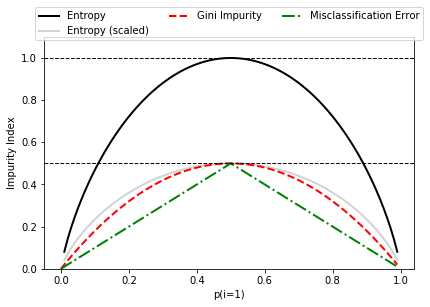

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.tight_layout()
#plt.savefig('./figures/impurity.png', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
def versiontuple(v):
    return tuple(map(int, (v.split("."))))

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

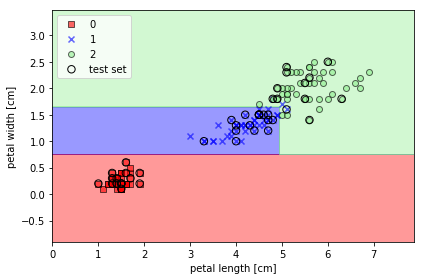

In [4]:
from sklearn import datasets
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

# Irisデータセットをロード
iris = datasets.load_iris()
# 3,4列目の特徴量を抽出
X = iris.data[:, [2, 3]]
# クラスラベルを取得
y = iris.target
# print('Class labels:', np.unique(y))

# テストデータの分離
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/decision_tree_decision.png', dpi=300)
plt.show()

## ランダムフォレスト
直感的には、決定木の「アンサンブル」。4つのステップは、

1. 大きさ\\( n \\)のランダムな「ブートストラップ」標本を復元抽出(重複を許したデータの抽出）する。（トレーニングデータセットから\\( n個のサンプルをランダムに選択する \\)）
1. ブートストラップ標本から決定木を成長させる。各ノードで以下の作業を行う
    1. \\( d \\)個の特徴量をランダムに非復元抽出（重複を許さないデータの抽出）する。
    1. 例えば情報利得を最大化することにより、目的関数に従って最適な分割となる特徴量を使ってノードを分割する。
1. ステップ1～2を\\( k \\)回繰り返す
1. 決定木ごとの予測をまとめて、「多数決に基づいてクラスラベルを割り当てる。

決定木との差はステップ2

* 決定木：全ての特徴量を評価する
* ランダムフォレスト：その一部をランダムに検討する

### 利点

* ハイパーパラメータに適切な値を設定することについてそれほど悩む必要がない。(ステップ3の\\( k \\)くらい)
* 個々の決定木のノイズにつようので選定する必要がない

### パラメータ設定

#### ブートストラップ標本の大きさ（ステップ1の\\( n \\)）

* \\( n \\)が大きい：ランダム性が低下し、過学習に陥りやすくなる
* \\( n \\)が小さい：ランダム性が上がり、過学習に陥りにくくなるが、モデルの性能が下がる

通常、ブートストラップ標本の大きさは元のトレーニングデータセットのサンプルの個数と等しくなる。

#### 分割ごとにランダムに選択される特徴量の個数（ステップ2-Aの\\( d \\)）

トレーニングデータセットの特徴量の合計数よりも小さい値を選択する必要がある。

デフォルト値は\\( d = \sqrt{m} \\)

\\( m \\)はトレーニングデータセットの特徴量の個数

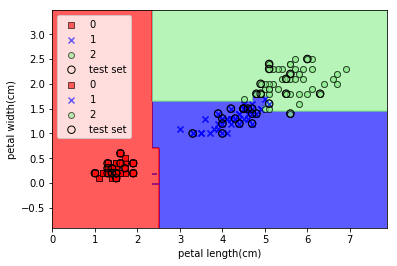

In [9]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1, n_jobs=2)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx=range(105, 150))
plt.xlabel('petal length(cm)')
plt.ylabel('petal width(cm)')
plt.legend(loc='upper left')
plt.show()